In [1]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from swdf.plots import *

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Predictions with Ap and Dst Indices Forecast Model (TSR Decomposition)

This notebook compiles various plots of predictions generated by the trained model to evaluate its performance. 

In [2]:
config_tsr = yaml2dict('./config/tsr_decomposition', attrdict=True).data
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).data
config = AttrDict({
    **config_tsr,
    "geodstap_data": AttrDict({**config_geodstap})
})
config

```json
{ 'data_columns': [ 'DST_Trend',
                    'DST_Seasonal',
                    'DST_Residual',
                    'AP_Trend',
                    'AP_Seasonal',
                    'AP_Residual'],
  'data_nb': './geodstap_tsr_data.ipynb',
  'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
  'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap_tsr.pkl',
  'geodstap_data': { 'add_time_channels': False,
                     'ap_config': './config/geoap.yaml',
                     'data_columns': ['DST', 'AP'],
                     'data_nb': './geodstap_data.ipynb',
                     'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
                     'dst_config': './config/geodst.yaml',
                     'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap.pkl',
                     'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'},
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
  'tsa_model': 'additive'}
```

In [3]:
df = load_object(config.df_save_path) 
df_geodstap = load_object(config.geodstap_data.df_save_path)
model_data = torch.load("models/best/best_model_tsr_geodstap.pth")

data_columns = model_data['data_columns']
components = model_data['components']
lookback = model_data['lookback']
horizon = model_data['horizon']
models = model_data['models']
df

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


In [4]:
def get_forecast_tensor(component:str, lookback_data):
    return torch.tensor(lookback_data.values.T).float().unsqueeze(0).cpu()

In [5]:
with torch.no_grad():
    predictions = torch.zeros((1, len(data_columns), horizon))
    for component, model in models.items():
        lookback_data = df[[index + f"_{component}" for index in ['AP', 'DST']]].iloc[-(lookback+horizon):-horizon]
        model.cpu().eval()
        predictions += model(get_forecast_tensor(component, lookback_data))

preds_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
true_df = df_geodstap[df_geodstap.Datetime > df_geodstap.Datetime.max()-pd.DateOffset(hours=horizon*3)]

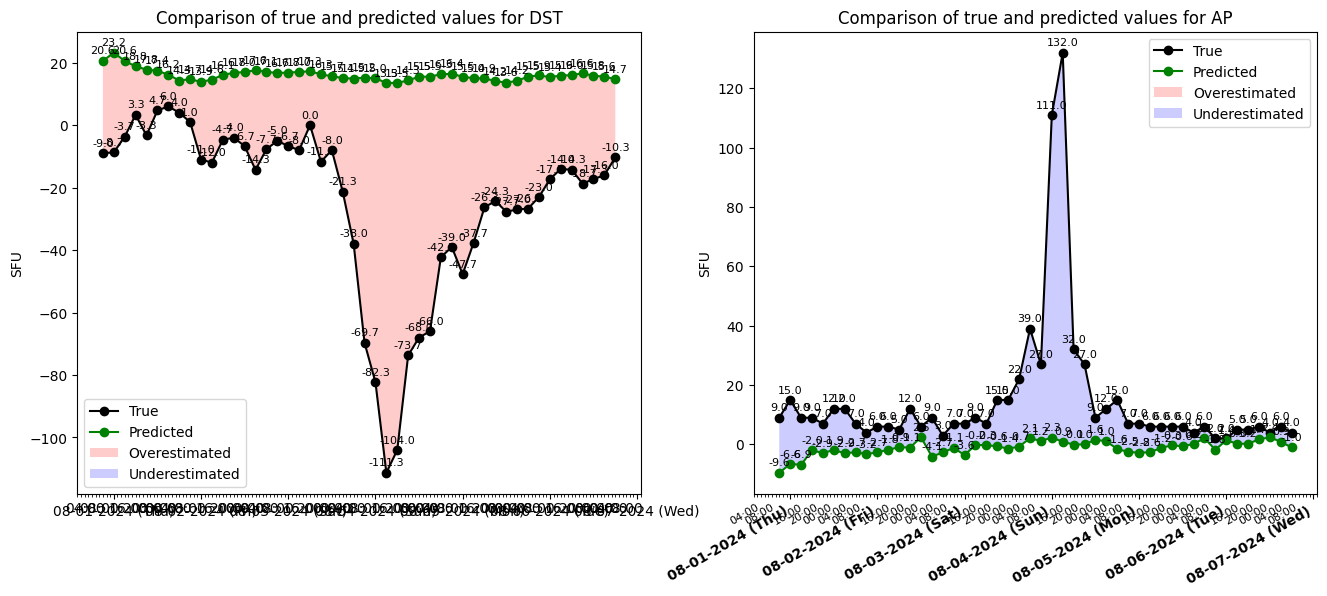

In [6]:
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

Timestamp('2024-08-07 06:00:00')

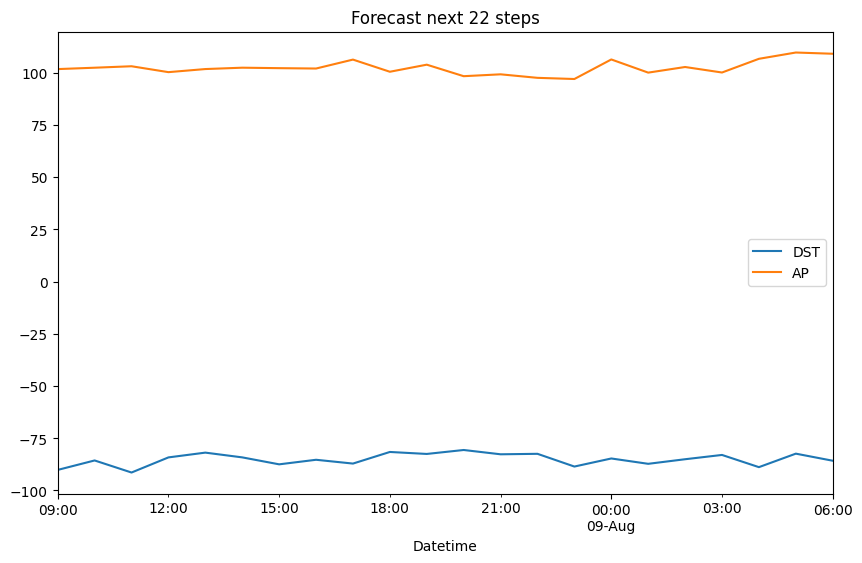

In [7]:
steps_to_forecast = 22
to_forecast_df = df.iloc[-lookback:]

def recurent_forecasting(df, days_to_forecast=12):
    to_forecast_df = df_geodstap.copy()
    forecasted_days = 0

    while forecasted_days < days_to_forecast:
        lookback_data = to_forecast_df[data_columns].iloc[-lookback:]

        with torch.no_grad():
            predictions = torch.zeros((1, len(data_columns), horizon))
            for component, model in models.items():
                model.eval()
                predictions += model(get_forecast_tensor(component, lookback_data))
    
        dates = [to_forecast_df.Datetime.max() + dt.timedelta(hours=j) for j in range(1, horizon+1)]
        pred_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
        pred_df['Datetime'] = dates
        to_forecast_df = pd.concat([to_forecast_df, pred_df], axis=0, ignore_index=True).reset_index(drop=True)
        
        forecasted_days += len(dates)
    
    return to_forecast_df

forecasts = recurent_forecasting(to_forecast_df, steps_to_forecast)
forecasts.iloc[-steps_to_forecast:].plot(x='Datetime', y=data_columns, figsize=(10, 6), title=f'Forecast next {steps_to_forecast} steps')
    


df.Datetime.max()

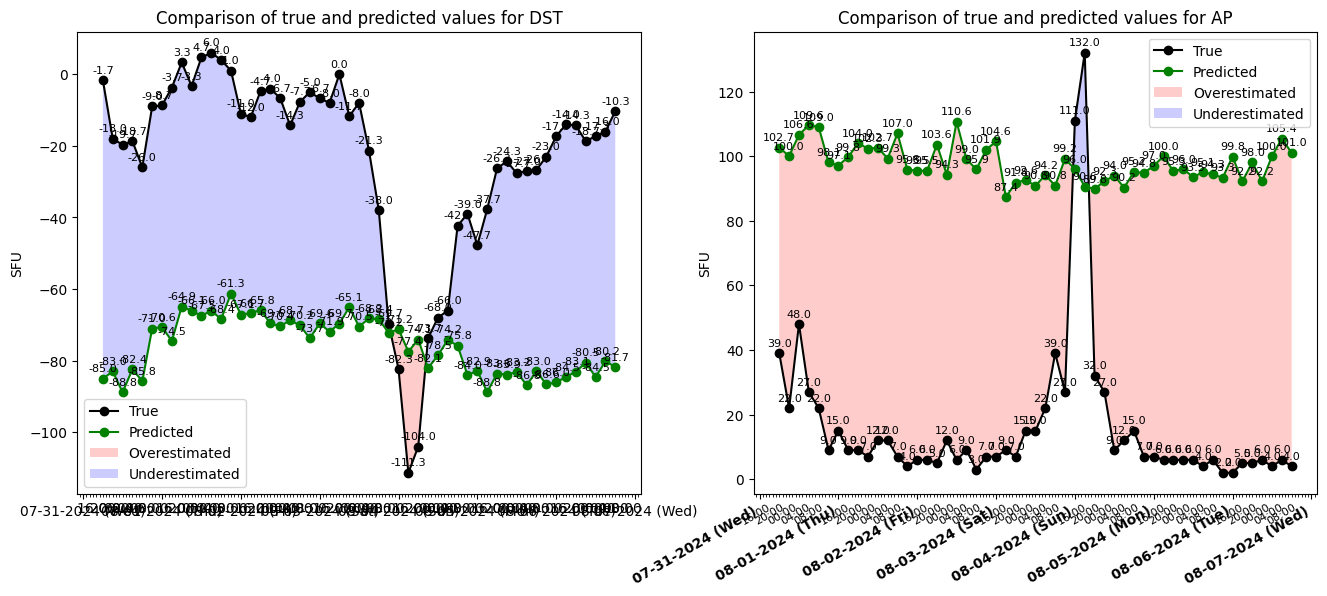

In [9]:
steps_to_forecast = 50

to_forecast_df = df.iloc[-(lookback+steps_to_forecast):-steps_to_forecast]

preds_df = recurent_forecasting(to_forecast_df, steps_to_forecast)[data_columns].iloc[-(steps_to_forecast+3):]
true_df = df_geodstap[data_columns + ['Datetime']].iloc[-(steps_to_forecast + 3):]
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

In [14]:
def get_forecast_tensor_by_dates(condition:str, start_date:pd.Timestamp, end_date:pd.Timestamp):
    measeures_per_day = 8

    lookback_days = lookback/measeures_per_day
    horizon_days = horizon/measeures_per_day

    data_columns = [data_column + f"_{condition}" for data_column in ['AP', 'DST']]

    X, y = prepare_forecasting_data(df[(df.Datetime >= start_date - dt.timedelta(days=lookback_days+horizon_days))
                                        & (df.Datetime <= end_date + dt.timedelta(days=horizon_days))], 
                                    fcst_history=lookback, 
                                    fcst_horizon=horizon,
                                    x_vars=data_columns, 
                                    y_vars=data_columns)
    
    X_tensor = torch.from_numpy(X).float()
    return X_tensor.cpu()


start_date = pd.Timestamp('2024-05-10')
end_date = pd.Timestamp('2024-05-17')

with torch.no_grad():
    preds = None
    for component, model in models.items():
        X = get_forecast_tensor_by_dates(component, start_date, end_date)
        if preds is None: 
            preds = torch.zeros((X.shape[0], len(data_columns), horizon))
        
        model.cpu().eval()
        preds += model(X)


true_df = df_geodstap[(df_geodstap.Datetime >= start_date) & (df_geodstap.Datetime <= end_date)] 
preds[:,0:1,:].shape


torch.Size([106, 1, 48])

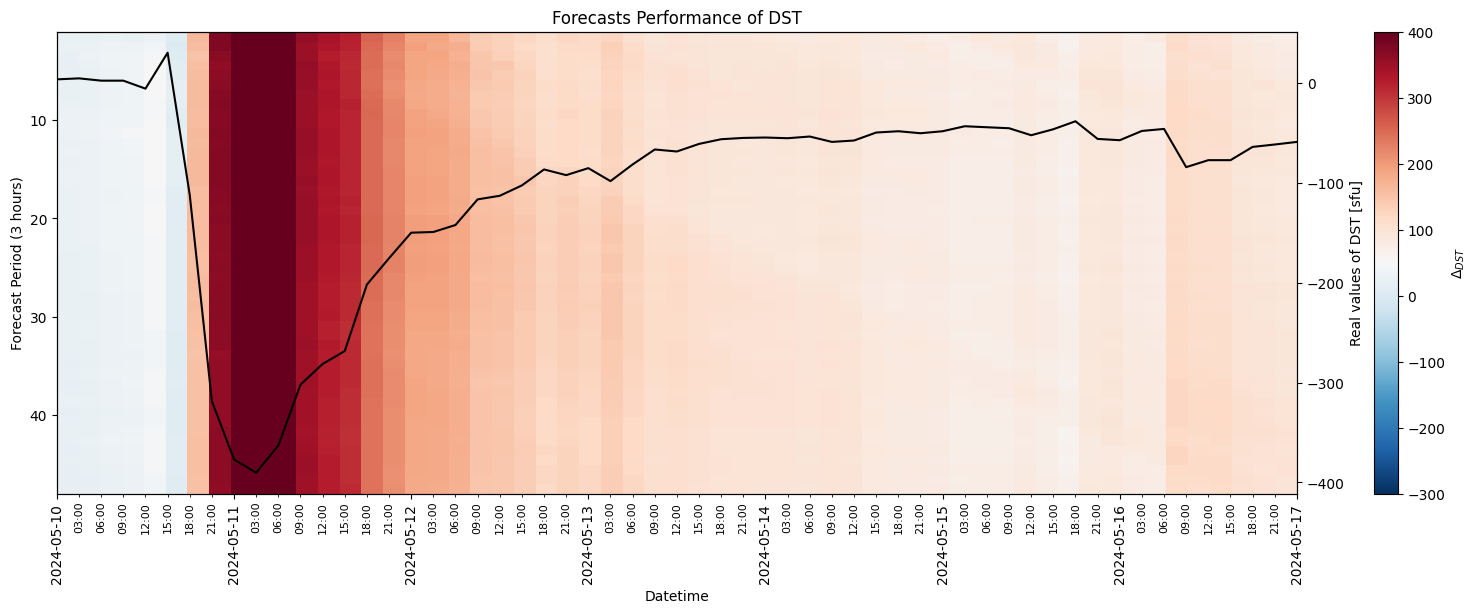

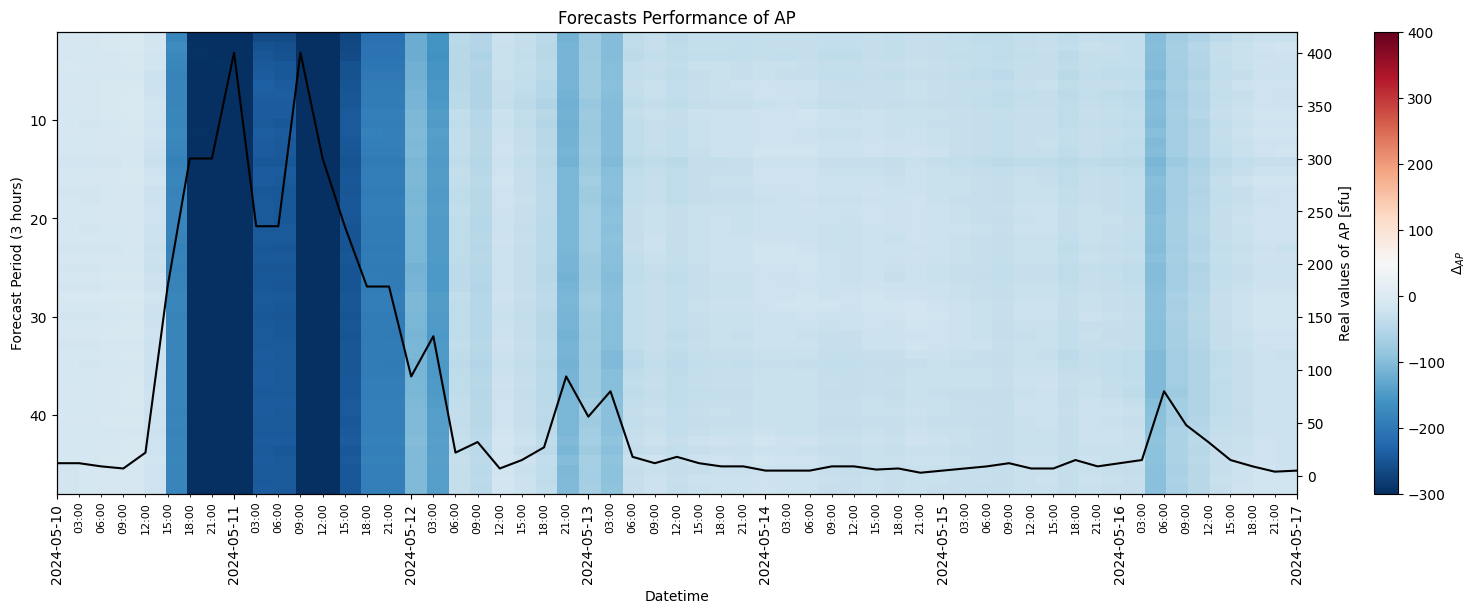

In [15]:

plot_histogram_with_accuracy_preds(
    true_df, 
    preds,
    data_columns=data_columns
)

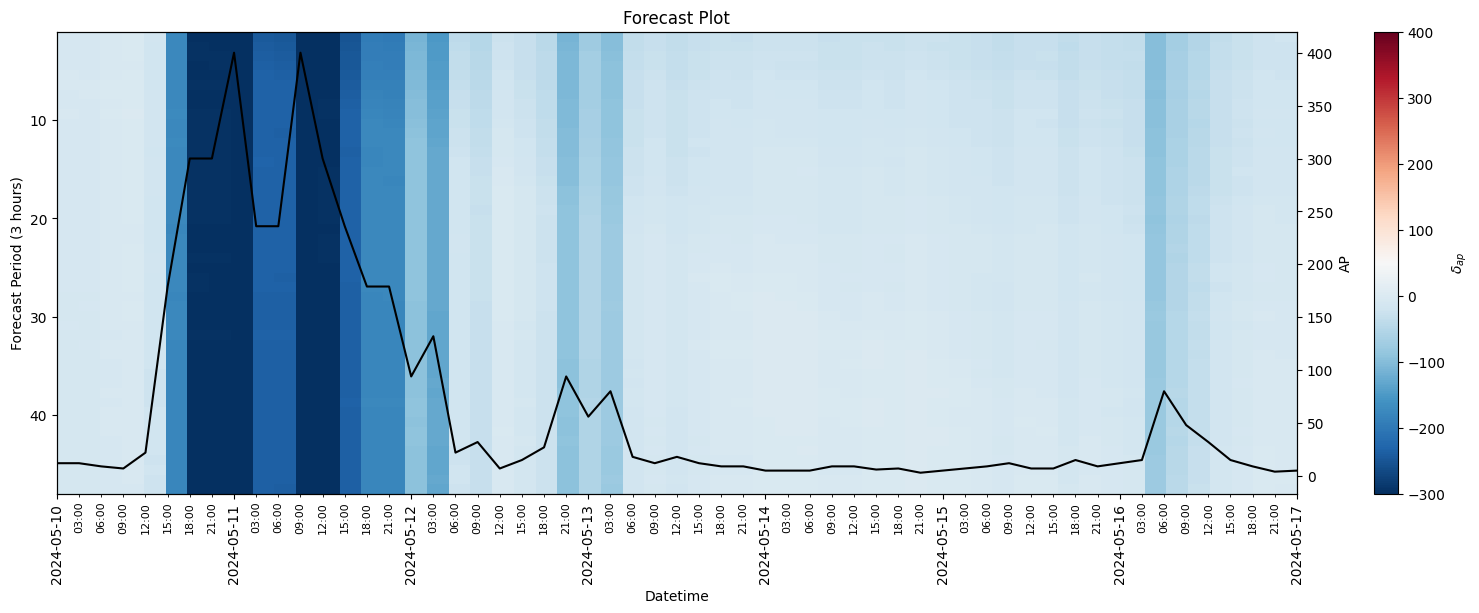

In [13]:
plot_histogram_with_preds_accuracy(true_df, preds[:,1:2,:], 'AP')